In [45]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [46]:

def parse_data_new() -> list:
    file_name = '../data/names_new.csv'
    with open(file_name, 'r') as f:
        data = f.read().splitlines()
    return [d.split(',')[0] for d in data]

def setup_data(data) -> tuple:
    clean_data = []
    valid_chars = 'âabcçdefgğhıiîjklmnoöprsştuüûvyz'
    for name in data:
        name = name.replace('İ', 'i') # Capital İ is two chars in ascii
        if all([c in valid_chars for c in name.lower()]):
            clean_data.append(name.lower())
    new_data = clean_data

    itos = {i+1:c for i, c in enumerate(valid_chars)}
    itos[0] = '.' # start and end token
    stoi = {c:i for i, c in itos.items()}

    return new_data, itos, stoi

data, itos, stoi = setup_data(parse_data_new())

In [47]:
# Hyper-parameters for the model
block_size = 5
num_dimensions = 10
num_hidden_neurons = 300
num_epochs = 100000
minibatch_size = 128

In [48]:
def build_dataset(words, block_size=3):
    xs, ys = [], [] 
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            idx = stoi[ch]
            xs.append(context)
            ys.append(idx)
            # print(''.join(itos[i] for i in context), '-->', itos[idx])
            context = context[1:] + [idx]
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

random.shuffle(data)
n1 = int(0.8 * len(data))
n2 = int(0.9 * len(data))
x_train, y_train = build_dataset(data[:n1],block_size)
x_val, y_val = build_dataset(data[n1:n2],block_size)
x_test, y_test = build_dataset(data[n2:],block_size)

In [51]:
# Cleaned version
g = torch.Generator().manual_seed(2147483647)

# Setting up parameters
C = torch.randn((len(stoi), num_dimensions), generator=g)
    
kaiming_scale = 5/3 * (num_dimensions * block_size)**0.5
W1 = torch.randn((num_dimensions * block_size, num_hidden_neurons), generator=g) / kaiming_scale
# b1 = torch.randn(num_hidden_neurons, generator=g) * 0.01

W2 = torch.randn((num_hidden_neurons, len(stoi)), generator=g) * 0.01
b2 = torch.randn(len(stoi), generator=g) * 0.01

bnorm_scale = torch.ones((1, num_hidden_neurons))
bnorm_bias = torch.zeros((1, num_hidden_neurons))

running_mean = torch.zeros((1, num_hidden_neurons))
running_std = torch.ones((1, num_hidden_neurons))

parameters = [C, W1, W2, b2, bnorm_scale, bnorm_bias] # b1

for p in parameters:
    p.requires_grad = True

In [52]:
# Why minibatch is better:
#   Its better to use approximate gradient and take more steps
#   than to take less steps towards exact gradient
step_i = []
loss_i = []

for e in range(num_epochs): 
    # Getting minibatches
    idx = torch.randint(0, x_train.shape[0], (minibatch_size,))

    # Forward pass
    emb = C[x_train[idx]]
    embcat = emb.view(-1, emb.shape[1] * emb.shape[2])
    hpreact = embcat @ W1 # + b1

    # --- batchnorm ---
    hmean = hpreact.mean(0, keepdim=True)
    hstd = hpreact.std(0, keepdim=True)
    hpreact_bn = ((hpreact - hmean) / hstd) * bnorm_scale + bnorm_bias

    # Updating running mean and std
    with torch.no_grad():
        running_mean = 0.999 * running_mean + 0.001 * hmean
        running_std = 0.999 * running_std + 0.001 * hstd
    # -----------------

    h = torch.tanh(hpreact_bn)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[idx])
    print(f"Epoch {e}:\t{loss.item()}", end='\r')

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    # lr = lrs[e]
    lr = 0.1 if e < num_epochs / 2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Logging
    step_i.append(e)
    loss_i.append(loss.item())

tensor(0.0042) tensor(0.9937)
tensor(-0.0070) tensor(0.1929)
tensor(0.0024) tensor(0.6067)


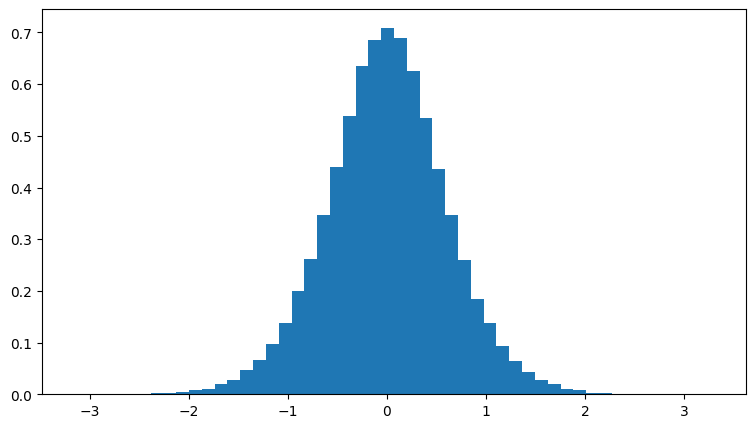

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 100) * 0.2
pre_act = x @ w

# print stats
print(x.mean(), x.std())
print(w.mean(), w.std())

# draw graphs
plt.figure(figsize=(20, 5))
# plt.subplot(121)
# plt.hist(x.view(-1).tolist(), bins=50, density=True);
plt.subplot(122)
plt.hist(pre_act.view(-1).tolist(), bins=50, density=True);
print(pre_act.mean(), pre_act.std())

In [ ]:
# preparing the mean and std for batchnorm on test data
with torch.no_grad():
    emb = C[x_train]
    embcat = emb.view(-1, emb.shape[1] * emb.shape[2])
    hpreact = embcat @ W1 + b1
    bn_mean = hpreact.mean(0, keepdim=True)
    bn_std = hpreact.std(0, keepdim=True)

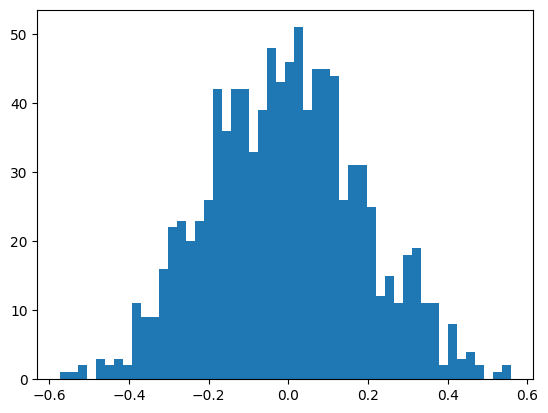

In [32]:
plt.hist(w.view(-1).tolist(), bins=50);

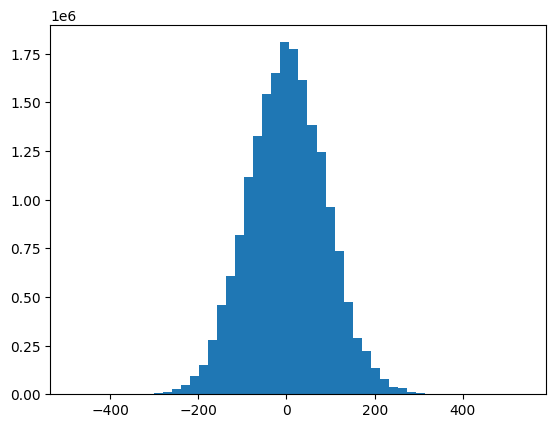

In [33]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

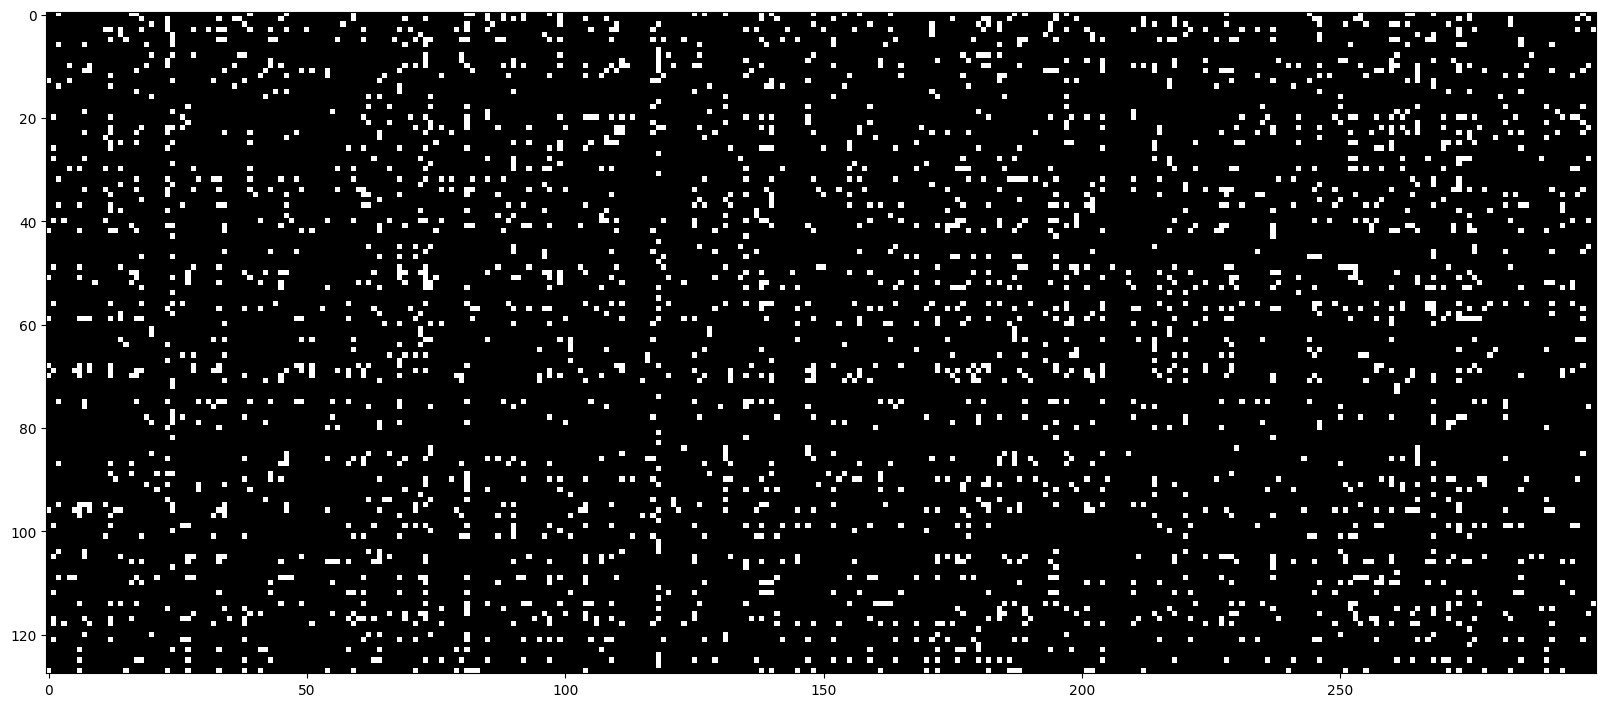

In [34]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, interpolation='nearest', cmap='gray');

In [35]:
@torch.no_grad()
def split_loss(split_name):
    split = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split_name]
    x, y = split
    emb = C[x]
    embcat = emb.view(-1, emb.shape[1] * emb.shape[2])
    hpreact = embcat @ W1 + b1
    hpreact_bn = ((hpreact - bn_mean) / bn_std) * bnorm_scale + bnorm_bias
    h = torch.tanh(hpreact_bn)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return loss

In [36]:
# Train loss of all the data
print(f"Train loss: {split_loss('train').item()}")

Train loss: 1.9881664514541626


In [37]:
# Validation loss of all the data
print(f"Validation loss: {split_loss('val').item()}")

Validation loss: 2.1343398094177246


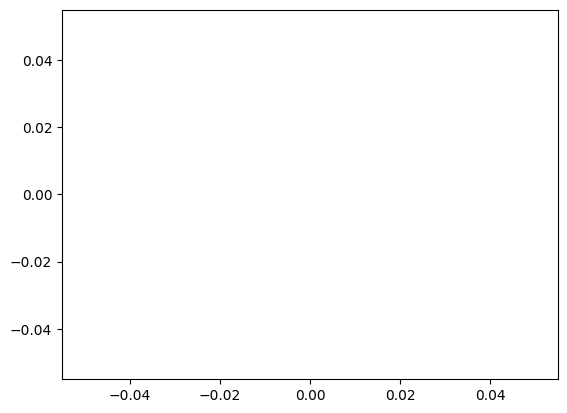

In [38]:
plt.plot(step_i, loss_i)

In [26]:
# Sampling from the model
num_samples = 20
for _ in range(num_samples):
    out = ''
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, 1).item()
        context = context[1:] + [idx]
        if idx == 0:
            break
        out += itos[idx]
    print(out)

akfişek
nerçan
mizile
hafel
şerzaf
rayılp
malcay
sayahan
buda
saria
dörsah
elgin
eldel
alproğalp
beral
şetrin
özüök
ili
toşus
altun
